In [1]:
# Cálcula el factor de reducción de área para datos en malla.

import numpy as np
import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt

from scipy import optimize

In [2]:
# Cargamos el archivo.
fdir = "../data/CHIRPS_megalopolis.nc"
ds_tot = xr.open_dataset( fdir )

# Ajustamos nombres.
ds_tot = ds_tot.rename_vars( { "longitude": "LONGITUD", "latitude": "LATITUD",
    "time": "TIEMPO", "precip": "PRECIPITACION" } ).swap_dims(
    { "longitude": "LONGITUD", "latitude": "LATITUD", "time": "TIEMPO" } 
    ).to_dataframe().to_xarray()

ds_tot

<xarray.Dataset>
Dimensions:        (TIEMPO: 15340, LONGITUD: 64, LATITUD: 52)
Coordinates:
  * TIEMPO         (TIEMPO) datetime64[ns] 1981-01-01 1981-01-02 ... 2022-12-31
  * LONGITUD       (LONGITUD) float64 -100.5 -100.4 -100.4 ... -97.38 -97.33
  * LATITUD        (LATITUD) float64 18.12 18.17 18.22 ... 20.57 20.62 20.67
Data variables:
    PRECIPITACION  (TIEMPO, LONGITUD, LATITUD) float32 0.0 0.0 0.0 ... 0.0 0.0

In [179]:
# Cálculo de ARF.

pre = "PRECIPITACION"
dur = [1, 2,  3,  4,  5, 10, 15, 20, 30, 40, 50, 60]
#dur = [1]

ds_trt = []

# Cantidad máxima de celdas a quitar de la orilla.
a = int( min( ds_tot["LONGITUD"].shape[0] / 2,
              ds_tot["LATITUD" ].shape[0] / 2 ) )
b = int( max( ds_tot["LONGITUD"].shape[0] / 2,
              ds_tot["LATITUD" ].shape[0] / 2 ) )
d = [None] * 4
d[0] = ( list( np.roll( np.repeat( np.arange(0, a), 4 ),
    -3 ) )[:-3] + list( np.arange(a, b) ) )
d[1] = ( list( np.roll( np.repeat( np.arange(0, a), 4 ),
    -2 ) )[:-3] + [a - 1] * (b - a) )
d[2] = ( list( np.roll( np.repeat( np.arange(0, a), 4 ),
    -1 ) )[:-3] + list( np.arange(a, b) ) )
d[3] = ( list( np.roll( np.repeat( np.arange(0, a), 4 ),
    0 ) )[:-3] + [a - 1] * (b - a) )
df_j = pd.DataFrame(d).T

# Iteramos para áreas decrecientes.
for j in df_j.itertuples():
    # Seleccionamos el área de estudio.
    ds_i = ds_tot.isel(
        { "LONGITUD": slice( j._1, ds_tot["LONGITUD"].shape[0] - j._3 ),
           "LATITUD": slice( j._2, ds_tot["LATITUD" ].shape[0] - j._4 ) } )

    # Cantidad de años de estudio.
    years = ds_i["TIEMPO"].dt.year.to_dataframe()["year"].unique()
    ny = years.shape[0]

    # SAM para cada celda.
    ds_tret = []
    # Iteramos para cada duración.
    for i in range( len(dur) ):
        # Creamos un dataset para colocar la SAM.
        ds_y = ds_i.isel( {"TIEMPO": range(0, ny) } ).copy()
        ds_tret.append( ds_y )
        ds_tret[i]["TIEMPO"] = years
        ds_p = ds_tret[i]["PRECIPITACION"]

        # Obtenemos la precipitación acumulada para la duración.
        ds_t = ds_i.rolling( {"TIEMPO": dur[i]} ).sum()
        # Obtenemos el máximo para cada año.
        for y in years:
            ds_p[ ds_p["TIEMPO"] == y ] = ( ds_t[pre].sel(
                { "TIEMPO": (ds_t["TIEMPO"].dt.year == y) }
                ).max(dim = "TIEMPO") )

        # Iteramos para cada celda.
        for lon in ds_tret[i]["LONGITUD"]:
            for lat in ds_tret[i]["LATITUD"]:
                # Ordenamos la SAM.
                df_p = ds_p[ :, ds_p["LONGITUD"] == lon,
                    ds_p["LATITUD"] == lat ].to_dataframe().sort_values( pre
                    ).reset_index().rename( {"TIEMPO": "AÑO"}, axis = 1 )
                df_p["TIEMPO"] = years
                df_p = df_p.set_index( ["TIEMPO", "LONGITUD", "LATITUD"] )
                # Asignamos los valores ordenados.
                ds_p[ :, ds_p["LONGITUD"] == lon, ds_p["LATITUD"] == lat ] = (
                    df_p.to_xarray()[pre] )

        # Calculamos el tiempo de retorno.
        ds_tret[i]["TIEMPO"] = ( ny + 1 ) / np.arange(ny, 0, -1)
        ds_tret[i] = ds_tret[i].rename_dims( {"TIEMPO": "TIEMPO_RETORNO"} 
                              ).rename_vars( {"TIEMPO": "TIEMPO_RETORNO"} )
    
        # Promediamos la SAM de todas las celdas.
        ds_tret[i] = ds_tret[i].mean( ["LONGITUD", "LATITUD"]
            ).expand_dims( {"DURACION": [dur[i]] } )

    ds_tret = xr.concat(ds_tret, "DURACION")

    # SAM para la precipitación media de la zona de estudio.
    df_i = ds_i.mean(
        ["LONGITUD", "LATITUD"] ).to_dataframe()
    df_i["CURVA_MASA"] = df_i["PRECIPITACION"].cumsum()

    # Iteramos para cada duración.
    for i in dur:
        # Obtenemos la precipitación acumulada para la duración.
        df_i[ i ] = ( ( df_i["CURVA_MASA"] - df_i["CURVA_MASA"].shift(i) ) )
    df_i.columns.name = "DURACION"
    # Obtenemos el máximo para cada año.
    df_i = df_i.drop( ["PRECIPITACION", "CURVA_MASA"],
        axis = 1 ).groupby( df_i.index.year ).max()
    # Ordenamos la SAM.
    df_i = df_i.apply( lambda x: x.sort_values(
        ascending = False ).values, axis = 0 )
    
    # Calculamos el tiempo de retorno.
    df_i = df_i.reset_index( drop = True )
    df_i.index.name = "TIEMPO_RETORNO"
    df_i.index += 1
    df_i.index = ( df_i.index[-1] + 1 ) / df_i.index
    df_i = df_i.sort_index()

    # Calculamos el ARF.
    ds_tret = df_i.stack().to_xarray() / ds_tret

    # Calculamos el área de estudio.
    ds_trt.append( ds_tret.expand_dims( { "AREA": [ (
        ds_i["LONGITUD"].shape[0] * 5 * ds_i["LATITUD"].shape[0] * 5 ) ] } ) )

ds_trt = xr.concat(ds_trt, "AREA").rename( {"PRECIPITACION": "ARF"} )

ds_trt.to_netcdf("../results/CHIRPS_megalopolis_ARF.nc")
ds_trt

<xarray.Dataset>
Dimensions:         (AREA: 107, DURACION: 12, TIEMPO_RETORNO: 42)
Coordinates:
  * AREA            (AREA) int64 83200 81900 80325 79050 ... 400 300 200 100
  * DURACION        (DURACION) int64 1 2 3 4 5 10 15 20 30 40 50 60
  * TIEMPO_RETORNO  (TIEMPO_RETORNO) float64 1.024 1.049 1.075 ... 21.5 43.0
Data variables:
    PRECIPITACION   (AREA, TIEMPO_RETORNO, DURACION) float32 0.6055 ... 1.0

In [37]:
ds_trt = xr.open_dataset("../results/CHIRPS_megalopolis_ARF.nc"
    )#.rename( {"PRECIPITACION": "ARF"} )
ds_trt

<xarray.Dataset>
Dimensions:         (AREA: 107, DURACION: 12, TIEMPO_RETORNO: 42)
Coordinates:
  * AREA            (AREA) int64 83200 81900 80325 79050 ... 400 300 200 100
  * DURACION        (DURACION) int64 1 2 3 4 5 10 15 20 30 40 50 60
  * TIEMPO_RETORNO  (TIEMPO_RETORNO) float64 1.024 1.049 1.075 ... 21.5 43.0
Data variables:
    ARF             (AREA, TIEMPO_RETORNO, DURACION) float32 ...

In [353]:
d = 60
df_d = ds_trt.to_dataframe().xs(d, level = "DURACION").unstack()
df_d

ARF                                                    \
TIEMPO_RETORNO 1.023810  1.048780  1.075000  1.102564  1.131579  1.162162    
AREA                                                                         
83200           0.929240  1.010971  0.978314  1.013881  1.013135  0.997842   
81900           0.924980  1.011586  0.982626  1.013910  1.012638  0.996717   
80325           0.923954  1.011598  0.981912  1.013015  1.007507  0.998355   
79050           0.927146  1.012803  0.977008  1.015963  1.009877  1.000615   
77500           0.931561  1.012737  0.975569  1.018204  1.012015  1.000533   
...                  ...       ...       ...       ...       ...       ...   
500             1.046599  1.035801  1.027697  1.007897  0.995039  1.008590   
400             1.040566  1.049381  1.036982  1.018069  1.001182  0.991765   
300             1.033534  1.037903  1.035861  1.023586  0.997194  0.986160   
200             1.014765  1.003498  1.008316  1.023867  1.003469  0.995667   
100             1.022394  0.994948  1.011233  1.026412  1.001494  0.998054   

                                                        ...            \
TIEMPO_RETORNO 1.194444  1.228571  1.264706  1.303030   ... 4.300000    
AREA                                                    ...             
83200           1.001079  0.996910  0.982814  0.975357  ...  0.925258   
81900           1.000245  0.995154  0.981891  0.973815  ...  0.925841   
80325           0.999738  0.991501  0.982031  0.970048  ...  0.926319   
79050           0.999296  0.994871  0.983219  0.972303  ...  0.926552   
77500           0.999822  0.996418  0.985037  0.974127  ...  0.924605   
...                  ...       ...       ...       ...  ...       ...   
500             1.001423  1.004125  1.003502  0.995995  ...  0.989248   
400             0.991390  0.989119  0.986583  0.983223  ...  1.014027   
300             0.980293  0.979263  0.985415  0.981998  ...  1.012097   
200             0.986421  0.979554  0.978100  1.000230  ...  1.000724   
100             0.997489  0.985513  0.987736  0.988283  ...  0.997607   

                                                                            \
TIEMPO_RETORNO 4.777778  5.375000  6.142857  7.166667  8.600000  10.750000   
AREA                                                                         
83200           0.911993  0.906727  0.890356  0.872768  0.872659  0.855587   
81900           0.914170  0.908144  0.891563  0.874793  0.872000  0.857612   
80325           0.917187  0.905302  0.892086  0.875135  0.869455  0.855113   
79050           0.912039  0.907001  0.892525  0.878731  0.870306  0.854403   
77500           0.914901  0.907535  0.893918  0.878791  0.871225  0.854867   
...                  ...       ...       ...       ...       ...       ...   
500             1.001051  1.001633  0.991378  0.991231  0.978642  1.000897   
400             1.004203  1.007835  0.998825  0.990225  0.991378  0.987468   
300             1.007106  1.009471  0.998092  0.997308  0.991566  0.973549   
200             1.013242  1.009285  1.005461  0.995752  0.990396  0.988047   
100             0.999695  1.010024  0.996261  0.985588  0.994475  0.992048   

                                              
TIEMPO_RETORNO 14.333333 21.500000 43.000000  
AREA                                          
83200           0.832599  0.835136  0.771634  
81900           0.834878  0.836101  0.772708  
80325           0.833480  0.837297  0.774091  
79050           0.828165  0.842247  0.776405  
77500           0.827494  0.841604  0.774877  
...                  ...       ...       ...  
500             0.971460  0.968604  0.934867  
400             0.981080  0.964907  0.947480  
300             0.993604  0.965490  0.958179  
200             0.982748  0.957108  0.989362  
100             0.979885  0.991823  1.000008  

[107 rows x 42 columns]

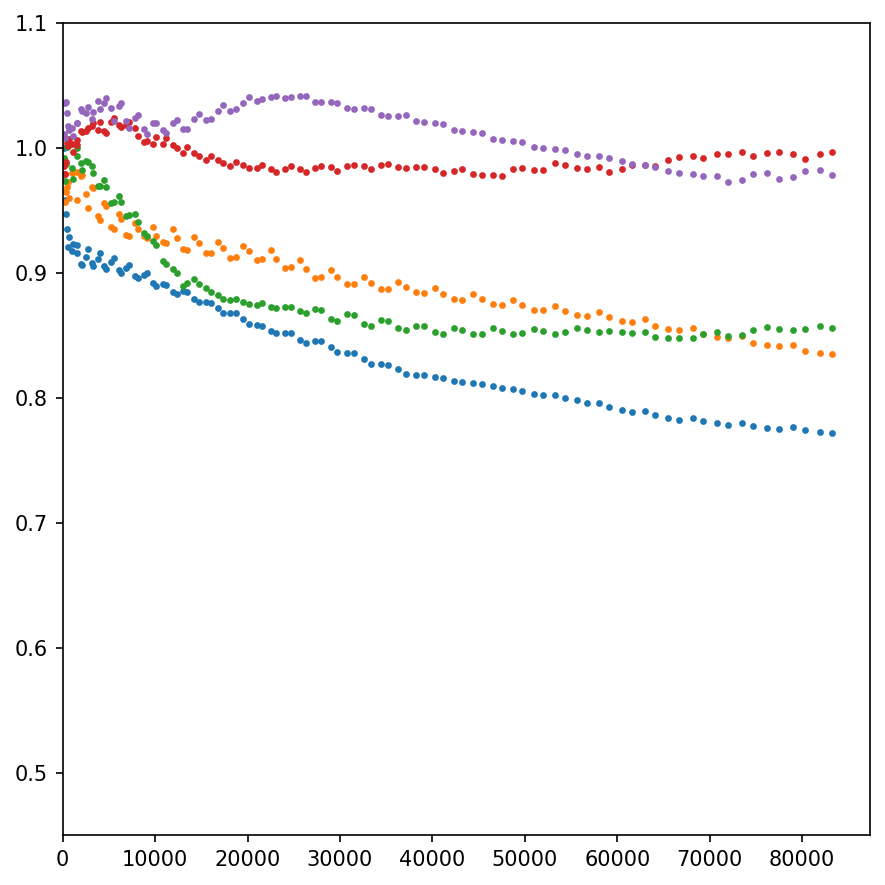

In [355]:
# Grafica de dispersión del error.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

ax.scatter( df_d.index, df_d.iloc[:, -1 ], s = 5 )
ax.scatter( df_d.index, df_d.iloc[:, -2 ], s = 5 )
ax.scatter( df_d.index, df_d.iloc[:, -4 ], s = 5 )
ax.scatter( df_d.index, df_d.iloc[:, -35], s = 5 )
ax.scatter( df_d.index, df_d.iloc[:, -40], s = 5 )

ax.set_xlim(0)
ax.set_ylim(0.45, 1.1)

fig.tight_layout()
plt.show()

In [46]:
T = 43
df_T = ds_trt.to_dataframe().xs(T, level = "TIEMPO_RETORNO").unstack()
df_T

ARF                                                    \
DURACION        1         2         3         4         5         10   
AREA                                                                   
83200     0.497283  0.658443  0.664480  0.635530  0.615041  0.630470   
81900     0.501820  0.663458  0.669803  0.641057  0.620431  0.635623   
80325     0.506652  0.670513  0.676435  0.647484  0.626669  0.641499   
79050     0.504120  0.666376  0.672147  0.643278  0.622262  0.633165   
77500     0.503895  0.664705  0.670220  0.641313  0.620775  0.628472   
...            ...       ...       ...       ...       ...       ...   
500       0.793897  0.814739  0.830391  0.866289  0.850168  0.905520   
400       0.833238  0.806642  0.881102  0.915468  0.877173  0.929552   
300       0.828417  0.887592  0.897543  0.946853  0.913445  0.945598   
200       0.766824  0.953015  0.955519  0.963916  0.953059  0.973608   
100       0.832434  0.952826  0.963443  0.996424  0.977700  0.995616   

                                                                      
DURACION        15        20        30        40        50        60  
AREA                                                                  
83200     0.655878  0.693991  0.784054  0.795364  0.764922  0.771634  
81900     0.657330  0.695614  0.785915  0.797098  0.765687  0.772708  
80325     0.657936  0.695317  0.787982  0.798722  0.766724  0.774091  
79050     0.661279  0.697286  0.791318  0.800533  0.768863  0.776405  
77500     0.661556  0.696604  0.790209  0.799988  0.767713  0.774877  
...            ...       ...       ...       ...       ...       ...  
500       0.929417  0.935492  0.957963  0.934054  0.925849  0.934867  
400       0.926553  0.923791  0.951735  0.926981  0.921880  0.947480  
300       0.941763  0.929275  0.941459  0.943988  0.935900  0.958179  
200       0.977059  0.947487  0.977948  0.984551  0.976219  0.989362  
100       0.990129  0.957066  0.998940  1.000015  1.000016  1.000008  

[107 rows x 12 columns]

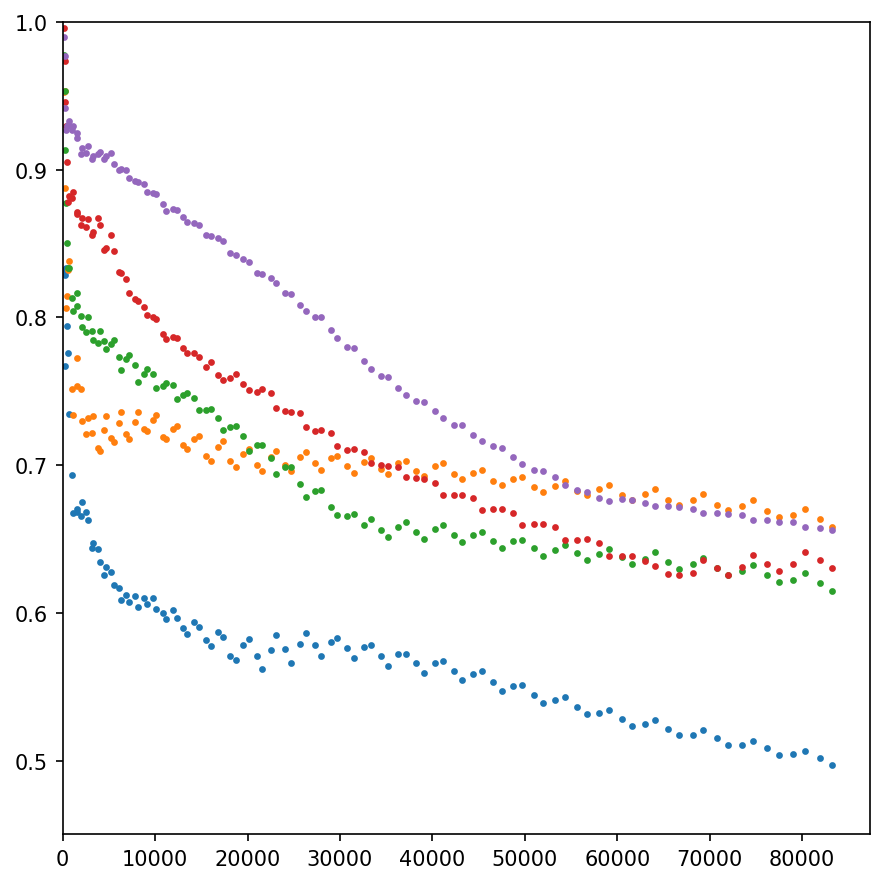

In [58]:
# Grafica de dispersión del error.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

ax.scatter( df_T.index, df_T.loc[:, ("ARF",  1) ], s = 5 )
ax.scatter( df_T.index, df_T.loc[:, ("ARF",  2) ], s = 5 )
ax.scatter( df_T.index, df_T.loc[:, ("ARF",  5) ], s = 5 )
ax.scatter( df_T.index, df_T.loc[:, ("ARF",  10) ], s = 5 )
ax.scatter( df_T.index, df_T.loc[:, ("ARF",  15) ], s = 5 )

ax.set_xlim(0)
ax.set_ylim(0.45, 1)

fig.tight_layout()
plt.show()

In [228]:
def arf(A, a, b, c):
    return 1 - np.exp( - 1 / ( a * ( A / c ) ** b ) )

df_calc = df_T.copy()
df_fit  = df_T.copy()
df_fit  = df_fit.T.iloc[:, [0, 1, 2]]
df_fit.columns = ["a", "b", "c"]

for d in df_fit.index.get_level_values("DURACION"):
    df_fit.loc[ ("ARF", d) ] = optimize.curve_fit( f = arf,
        xdata = df_T.index, ydata = df_T.loc[ :, ("ARF",  d) ],
        p0 = (0.1, 0.1, 0.1), full_output = True, maxfev = 10000 )[0]
    df_calc.loc[ :, ("ARF", d) ] = arf(
        df_calc.index, *df_fit.loc[ ("ARF", d) ] )

df_calc

ARF                                                    \
DURACION        1         2         3         4         5         10   
AREA                                                                   
83200     0.515152  0.665359  0.677178  0.629897  0.623004  0.631188   
81900     0.515842  0.665827  0.677684  0.630616  0.623883  0.632391   
80325     0.516694  0.666405  0.678308  0.631503  0.624967  0.633873   
79050     0.517396  0.666881  0.678821  0.632234  0.625860  0.635095   
77500     0.518266  0.667470  0.679457  0.633138  0.626966  0.636607   
...            ...       ...       ...       ...       ...       ...   
500       0.746147  0.809537  0.830239  0.846705  0.879957  0.944049   
400       0.755792  0.815226  0.836106  0.854571  0.888410  0.951196   
300       0.768065  0.822455  0.843532  0.864416  0.898813  0.959472   
200       0.785015  0.832436  0.853728  0.877704  0.912504  0.969414   
100       0.812908  0.848902  0.870386  0.898745  0.933223  0.982168   

                                                                      
DURACION        15        20        30        40        50        60  
AREA                                                                  
83200     0.661128  0.714565  0.810482  0.811749  0.777456  0.782657  
81900     0.662848  0.715893  0.811347  0.812466  0.778301  0.783457  
80325     0.664967  0.717529  0.812411  0.813349  0.779342  0.784441  
79050     0.666712  0.718875  0.813286  0.814075  0.780198  0.785251  
77500     0.668872  0.720539  0.814366  0.814972  0.781257  0.786252  
...            ...       ...       ...       ...       ...       ...  
500       0.993013  0.984790  0.982699  0.969960  0.967179  0.964571  
400       0.995032  0.987867  0.985271  0.973230  0.971026  0.968455  
300       0.996909  0.991097  0.988144  0.977055  0.975494  0.973002  
200       0.998528  0.994455  0.991432  0.981742  0.980907  0.978579  
100       0.999670  0.997795  0.995351  0.988042  0.988021  0.986071  

[107 rows x 12 columns]

In [87]:
df_fit

a         b          c
    DURACION                               
ARF 1         0.532502  0.124866  40.240612
    2         0.163651  0.081205   0.000053
    3         0.416887  0.088003  16.154467
    4         0.129993  0.124133   0.005765
    5         0.096007  0.151759   0.013905
    10        0.045052  0.207544   0.026798
    15        0.038887  0.297830   1.996795
    20        0.076077  0.235719   3.896427
    30        0.040401  0.174343   0.015635
    40        0.095555  0.144971   0.264385
    50        0.065073  0.160616   0.042994
    60        0.073271  0.153137   0.050955

In [103]:
df_fit["a"]

     DURACION
ARF  1           0.532502
     2           0.163651
     3           0.416887
     4           0.129993
     5           0.096007
     10          0.045052
     15          0.038887
     20          0.076077
     30          0.040401
     40          0.095555
     50          0.065073
     60          0.073271
Name: a, dtype: float32

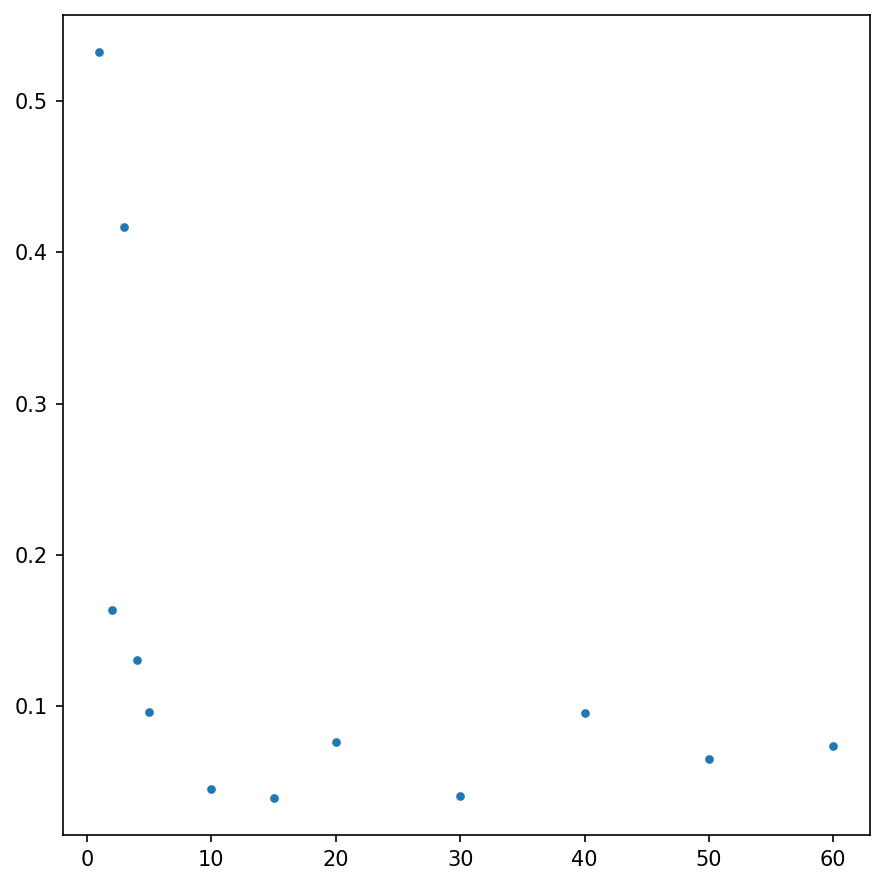

In [105]:
# Grafica de dispersión del error.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

ax.scatter( df_fit.index.get_level_values("DURACION"), df_fit["a"], s = 10 )

fig.tight_layout()
plt.show()

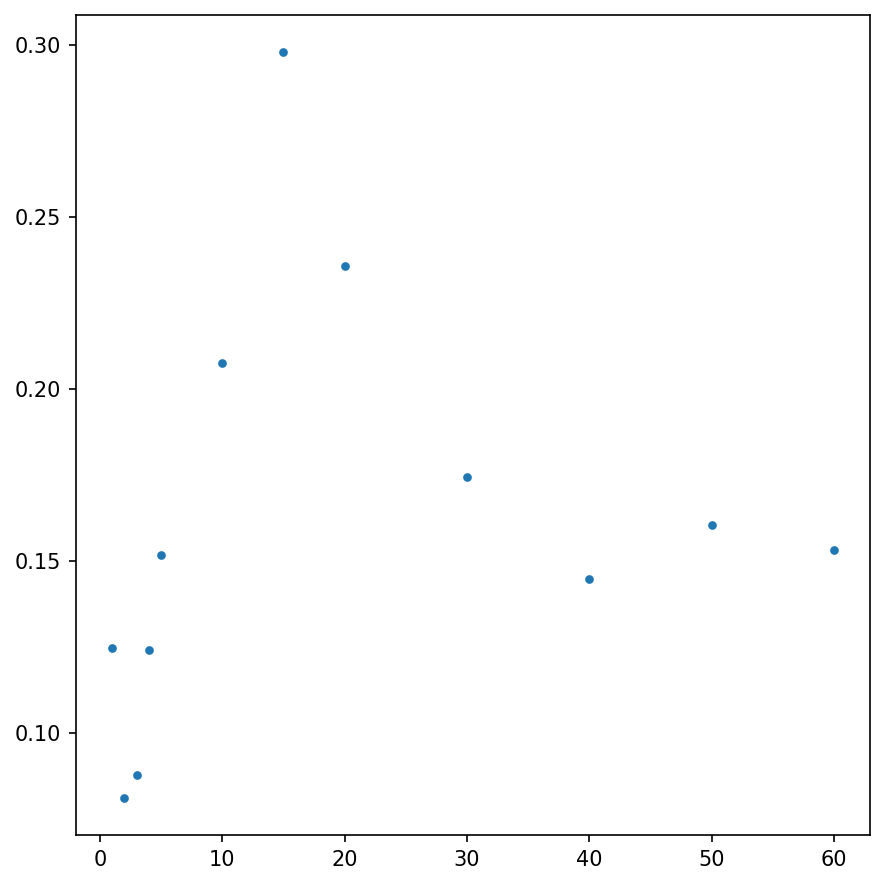

In [106]:
# Grafica de dispersión del error.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

ax.scatter( df_fit.index.get_level_values("DURACION"), df_fit["b"], s = 10 )

fig.tight_layout()
plt.show()

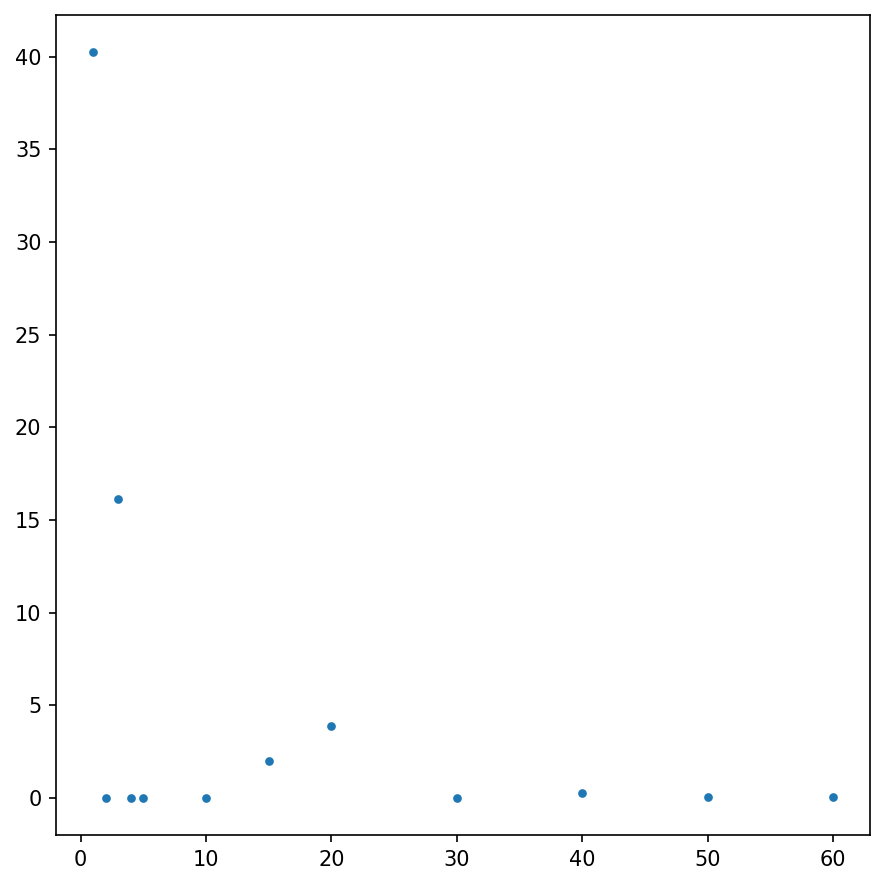

In [108]:
# Grafica de dispersión del error.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

ax.scatter( df_fit.index.get_level_values("DURACION"), df_fit["c"], s = 10 )

fig.tight_layout()
plt.show()

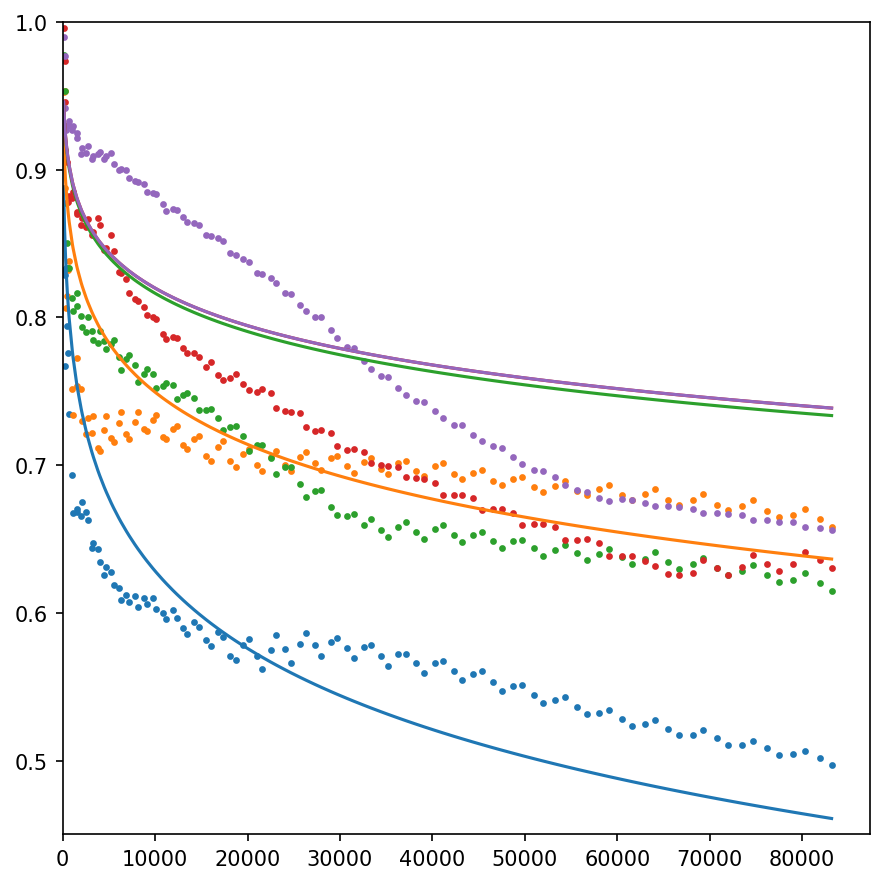

In [290]:
# Grafica de dispersión del error.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

ax.scatter( df_T.index, df_T.loc[:, ("ARF",  1) ], s = 5 )
ax.scatter( df_T.index, df_T.loc[:, ("ARF",  2) ], s = 5 )
ax.scatter( df_T.index, df_T.loc[:, ("ARF",  5) ], s = 5 )
ax.scatter( df_T.index, df_T.loc[:, ("ARF",  10) ], s = 5 )
ax.scatter( df_T.index, df_T.loc[:, ("ARF",  15) ], s = 5 )
ax.plot( df_calc.loc[ :, ("ARF", 1) ] )
ax.plot( df_calc.loc[ :, ("ARF", 2) ] )
ax.plot( df_calc.loc[ :, ("ARF", 5) ] )
ax.plot( df_calc.loc[ :, ("ARF", 10) ] )
ax.plot( df_calc.loc[ :, ("ARF", 15) ] )

ax.set_xlim(0)
ax.set_ylim(0.45, 1)

fig.tight_layout()
plt.show()

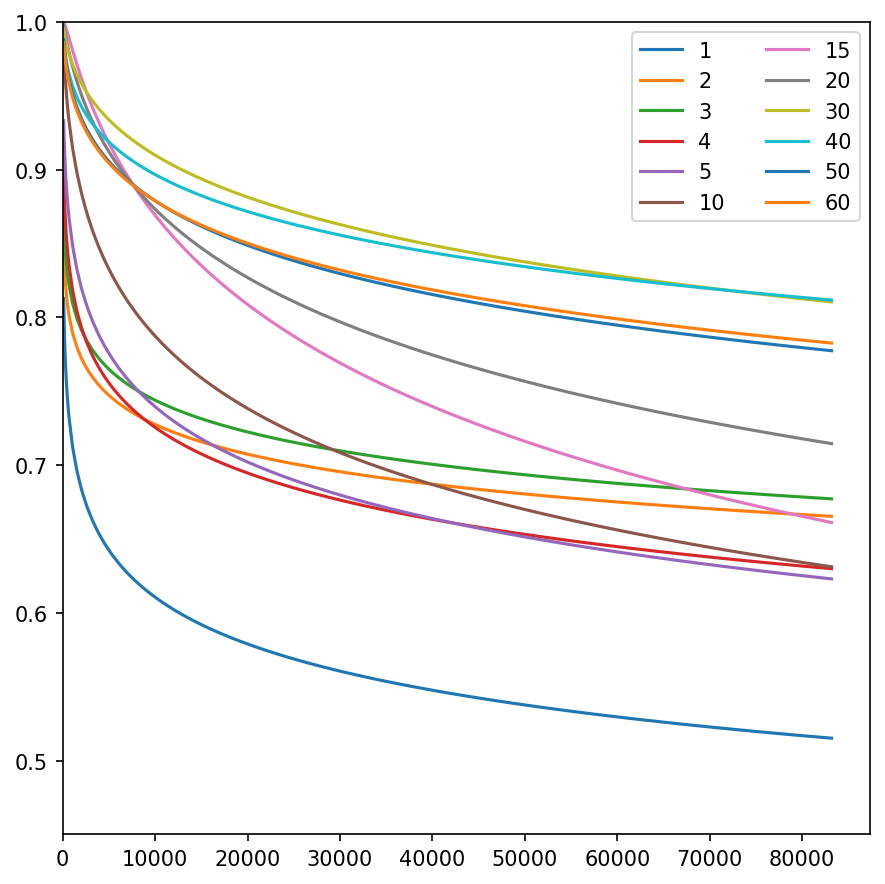

In [112]:
# Grafica de dispersión del error.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

ax.plot( df_calc )
ax.legend( df_fit.index.get_level_values("DURACION"), ncol = 2 )

ax.set_xlim(0)
ax.set_ylim(0.45, 1)

fig.tight_layout()
plt.show()

In [315]:
d = fit[0][3]
( 1 - d * np.exp( - X[1] ) )

array([2.06321431, 1.39113469, 1.14389041, ..., 1.        , 1.        ,
       1.        ])

In [309]:
fit[0]

array([ 0.10643905,  0.11549121,  0.00399942, -2.89011613])

In [359]:
def arf(X, a, b, c, d, e, f):
    F = ( np.exp( 1 / ( d * ( X[1] / e ) ** f ) ) )
    G = np.exp( - 1 / ( a * ( X[0] / c ) ** b ) )
    return 1 - F * G

pred = df_T.stack().reset_index()
X = pred.iloc[:, [0, 1]].values.T
Y = pred.iloc[:, 2].values

fit = optimize.curve_fit( f = arf,
    xdata = X, ydata = Y,
    p0 = [0.1] * 6, full_output = True, maxfev = 10000 )
df_calc = pred.copy()
df_calc["ARF"] = arf(X, *fit[0])
df_calc = df_calc.set_index( ["AREA", "DURACION"] ).unstack()
df_calc

/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_3408/1238228466.py:2: RuntimeWarning: invalid value encountered in power
  F = ( np.exp( 1 / ( d * ( X[1] / e ) ** f ) ) )
/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_3408/1238228466.py:3: RuntimeWarning: invalid value encountered in power
  G = np.exp( - 1 / ( a * ( X[0] / c ) ** b ) )


ARF                                                    \
DURACION        1         2         3         4         5         10   
AREA                                                                   
100       0.858252  0.880623  0.892032  0.899459  0.904865  0.919871   
200       0.838197  0.863733  0.876756  0.885234  0.891405  0.908534   
300       0.825176  0.852767  0.866839  0.875998  0.882666  0.901174   
400       0.815309  0.844457  0.859323  0.868999  0.876043  0.895596   
500       0.807273  0.837690  0.853202  0.863300  0.870650  0.891053   
...            ...       ...       ...       ...       ...       ...   
77500     0.495732  0.575316  0.615905  0.642325  0.661558  0.714942   
79050     0.493825  0.573710  0.614453  0.640972  0.660278  0.713864   
80325     0.492280  0.572409  0.613275  0.639876  0.659241  0.712991   
81900     0.490397  0.570823  0.611841  0.638541  0.657977  0.711926   
83200     0.488866  0.569533  0.610675  0.637454  0.656949  0.711061   

                                                                      
DURACION        15        20        30        40        50        60  
AREA                                                                  
100       0.927525  0.932508  0.938953  0.943149  0.946203  0.948576  
200       0.917271  0.922958  0.930316  0.935105  0.938592  0.941301  
300       0.910614  0.916759  0.924708  0.929883  0.933650  0.936577  
400       0.905568  0.912060  0.920458  0.925925  0.929905  0.932997  
500       0.901460  0.908234  0.916998  0.922702  0.926855  0.930082  
...            ...       ...       ...       ...       ...       ...  
77500     0.742171  0.759896  0.782825  0.797751  0.808618  0.817061  
79050     0.741196  0.758988  0.782004  0.796986  0.807894  0.816369  
80325     0.740406  0.758252  0.781338  0.796366  0.807307  0.815808  
81900     0.739443  0.757355  0.780527  0.795611  0.806593  0.815125  
83200     0.738660  0.756626  0.779868  0.794997  0.806012  0.814570  

[107 rows x 12 columns]

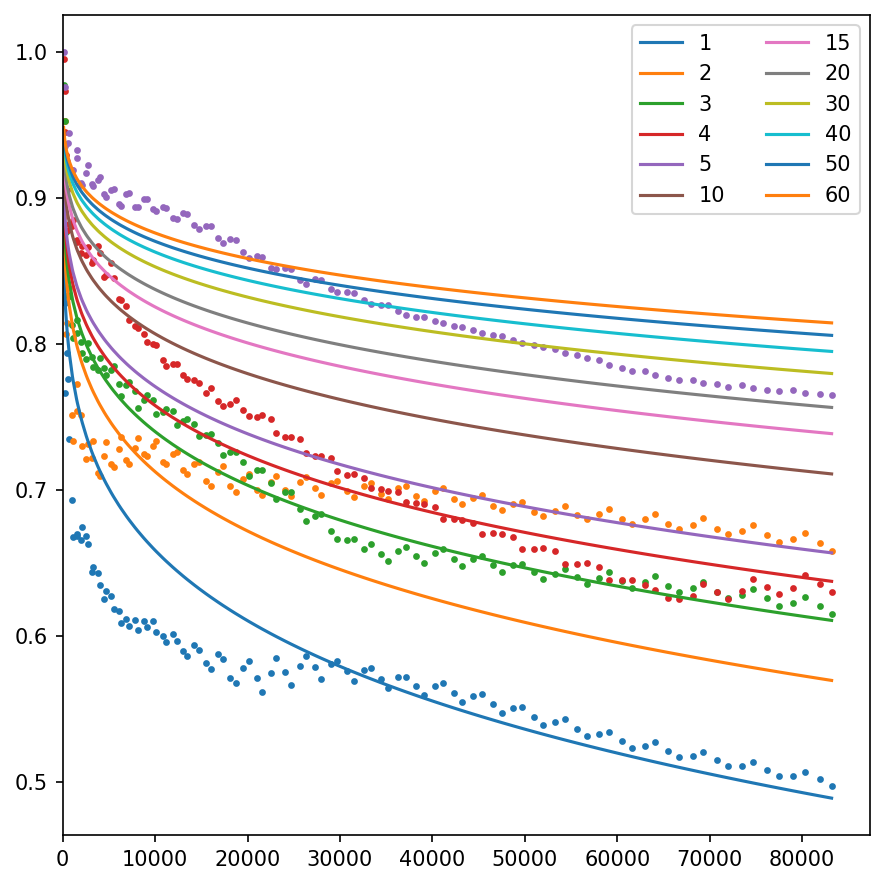

In [331]:
# Grafica de dispersión del error.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

ax.plot( df_calc )
ax.legend( df_fit.index.get_level_values("DURACION"), ncol = 2 )
ax.scatter( df_T.index, df_T.loc[:, ("ARF",  1) ], s = 5 )
ax.scatter( df_T.index, df_T.loc[:, ("ARF",  2) ], s = 5 )
ax.scatter( df_T.index, df_T.loc[:, ("ARF",  5) ], s = 5 )
ax.scatter( df_T.index, df_T.loc[:, ("ARF",  10) ], s = 5 )
ax.scatter( df_T.index, df_T.loc[:, ("ARF",  50) ], s = 5 )

ax.set_xlim(0)
#ax.set_ylim(0.45, 1)

fig.tight_layout()
plt.show()

In [377]:
def arf(X, a, b, c, d, e, f, g, h, i):
    F = np.exp(   1 / ( d * ( X[1] / e ) ** f ) )
    G = np.exp( - 1 / ( g * ( X[2] / h ) ** i ) )
    H = np.exp( - 1 / ( a * ( X[0] / c ) ** b ) )
    #return 1 - F * ( G + H )
    return (1 - F * G ) * (1 - F * H )

pred = ds_trt.to_dataframe().reset_index()
X = pred.iloc[:, [0, 1, 2]].values.T
Y = pred.iloc[:, 3].values

fit = optimize.curve_fit( f = arf,
    xdata = X, ydata = Y,
    p0 = [0.1] * 9, full_output = True, maxfev = 10000 )
df_calc = pred.copy()
df_calc["ARF"] = arf(X, *fit[0])
df_calc = df_calc.set_index( ["AREA", "DURACION", "TIEMPO_RETORNO"] ).unstack()
df_calc

/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_3408/1754898625.py:2: RuntimeWarning: invalid value encountered in power
  F = np.exp(   1 / ( d * ( X[1] / e ) ** f ) )
/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_3408/1754898625.py:3: RuntimeWarning: invalid value encountered in power
  G = np.exp( - 1 / ( g * ( X[2] / h ) ** i ) )
/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_3408/1754898625.py:4: RuntimeWarning: invalid value encountered in power
  H = np.exp( - 1 / ( a * ( X[0] / c ) ** b ) )


ARF                                                    \
TIEMPO_RETORNO 1.023810  1.048780  1.075000  1.102564  1.131579  1.162162    
AREA  DURACION                                                               
100   1         0.905834  0.905273  0.904692  0.904090  0.903465  0.902816   
      2         0.929946  0.929527  0.929093  0.928643  0.928176  0.927690   
      3         0.941121  0.940768  0.940402  0.940023  0.939629  0.939221   
      4         0.947965  0.947652  0.947328  0.946993  0.946645  0.946283   
      5         0.952726  0.952442  0.952148  0.951843  0.951526  0.951197   
...                  ...       ...       ...       ...       ...       ...   
83200 20        0.865099  0.864959  0.864815  0.864665  0.864510  0.864349   
      30        0.886668  0.886549  0.886425  0.886297  0.886164  0.886025   
      40        0.899865  0.899759  0.899648  0.899533  0.899414  0.899291   
      50        0.909043  0.908945  0.908843  0.908738  0.908629  0.908516   
      60        0.915917  0.915826  0.915732  0.915634  0.915533  0.915428   

                                                        ...            \
TIEMPO_RETORNO 1.194444  1.228571  1.264706  1.303030   ... 4.300000    
AREA  DURACION                                          ...             
100   1         0.902141  0.901439  0.900707  0.899944  ...  0.859524   
      2         0.927186  0.926661  0.926114  0.925543  ...  0.895323   
      3         0.938796  0.938353  0.937893  0.937412  ...  0.911955   
      4         0.945907  0.945515  0.945108  0.944682  ...  0.922154   
      5         0.950855  0.950499  0.950128  0.949741  ...  0.929255   
...                  ...       ...       ...       ...  ...       ...   
83200 20        0.864181  0.864007  0.863825  0.863635  ...  0.853588   
      30        0.885882  0.885732  0.885576  0.885414  ...  0.876803   
      40        0.899162  0.899028  0.898889  0.898743  ...  0.891044   
      50        0.908398  0.908276  0.908148  0.908015  ...  0.900963   
      60        0.915318  0.915204  0.915086  0.914962  ...  0.908403   

                                                                            \
TIEMPO_RETORNO 4.777778  5.375000  6.142857  7.166667  8.600000  10.750000   
AREA  DURACION                                                               
100   1         0.854831  0.849321  0.842720  0.834602  0.824262  0.810427   
      2         0.891815  0.887696  0.882760  0.876691  0.868961  0.858617   
      3         0.909000  0.905530  0.901373  0.896260  0.889748  0.881035   
      4         0.919538  0.916468  0.912788  0.908264  0.902501  0.894790   
      5         0.926877  0.924085  0.920739  0.916624  0.911384  0.904372   
...                  ...       ...       ...       ...       ...       ...   
83200 20        0.852422  0.851053  0.849412  0.847394  0.844824  0.841385   
      30        0.875803  0.874629  0.873223  0.871493  0.869291  0.866343   
      40        0.890150  0.889100  0.887843  0.886296  0.884327  0.881691   
      50        0.900145  0.899183  0.898032  0.896615  0.894812  0.892398   
      60        0.907642  0.906748  0.905677  0.904359  0.902682  0.900437   

                                              
TIEMPO_RETORNO 14.333333 21.500000 43.000000  
AREA  DURACION                                
100   1         0.790467  0.757688  0.686186  
      2         0.843694  0.819188  0.765730  
      3         0.868464  0.847820  0.802789  
      4         0.883665  0.865396  0.825545  
      5         0.894256  0.877643  0.841404  
...                  ...       ...       ...  
83200 20        0.836424  0.828277  0.810505  
      30        0.862091  0.855108  0.839876  
      40        0.877889  0.871645  0.858024  
      50        0.888916  0.883197  0.870723  
      60        0.897198  0.891880  0.880278  

[1284 rows x 42 columns]

In [379]:
df_calc.xs(1, level = "DURACION")

ARF                                                    \
TIEMPO_RETORNO 1.023810  1.048780  1.075000  1.102564  1.131579  1.162162    
AREA                                                                         
100             0.905834  0.905273  0.904692  0.904090  0.903465  0.902816   
200             0.894880  0.894326  0.893752  0.893157  0.892540  0.891899   
300             0.887111  0.886561  0.885993  0.885403  0.884791  0.884155   
400             0.880882  0.880337  0.879772  0.879186  0.878579  0.877948   
500             0.875595  0.875053  0.874492  0.873910  0.873306  0.872679   
...                  ...       ...       ...       ...       ...       ...   
77500           0.531131  0.530802  0.530462  0.530108  0.529742  0.529362   
79050           0.528225  0.527898  0.527560  0.527208  0.526844  0.526466   
80325           0.525863  0.525537  0.525200  0.524850  0.524488  0.524111   
81900           0.522977  0.522654  0.522318  0.521971  0.521610  0.521235   
83200           0.520623  0.520301  0.519967  0.519621  0.519262  0.518889   

                                                        ...            \
TIEMPO_RETORNO 1.194444  1.228571  1.264706  1.303030   ... 4.300000    
AREA                                                    ...             
100             0.902141  0.901439  0.900707  0.899944  ...  0.859524   
200             0.891232  0.890538  0.889815  0.889061  ...  0.849130   
300             0.883495  0.882807  0.882090  0.881343  ...  0.841758   
400             0.877292  0.876609  0.875897  0.875155  ...  0.835848   
500             0.872026  0.871348  0.870640  0.869902  ...  0.830831   
...                  ...       ...       ...       ...  ...       ...   
77500           0.528966  0.528554  0.528125  0.527678  ...  0.503977   
79050           0.526072  0.525663  0.525236  0.524791  ...  0.501220   
80325           0.523719  0.523311  0.522887  0.522444  ...  0.498978   
81900           0.520846  0.520440  0.520018  0.519577  ...  0.496241   
83200           0.518501  0.518097  0.517677  0.517238  ...  0.494006   

                                                                            \
TIEMPO_RETORNO 4.777778  5.375000  6.142857  7.166667  8.600000  10.750000   
AREA                                                                         
100             0.854831  0.849321  0.842720  0.834602  0.824262  0.810427   
200             0.844494  0.839051  0.832529  0.824509  0.814295  0.800627   
300             0.837162  0.831766  0.825302  0.817351  0.807225  0.793676   
400             0.831285  0.825927  0.819507  0.811613  0.801558  0.788104   
500             0.826295  0.820970  0.814589  0.806741  0.796747  0.783374   
...                  ...       ...       ...       ...       ...       ...   
77500           0.501226  0.497995  0.494125  0.489365  0.483302  0.475190   
79050           0.498484  0.495271  0.491421  0.486687  0.480658  0.472590   
80325           0.496254  0.493056  0.489223  0.484510  0.478508  0.470476   
81900           0.493531  0.490350  0.486539  0.481852  0.475883  0.467895   
83200           0.491309  0.488143  0.484349  0.479683  0.473740  0.465789   

                                              
TIEMPO_RETORNO 14.333333 21.500000 43.000000  
AREA                                          
100             0.790467  0.757688  0.686186  
200             0.780908  0.748526  0.677888  
300             0.774129  0.742027  0.672003  
400             0.768694  0.736818  0.667285  
500             0.764080  0.732395  0.663280  
...                  ...       ...       ...  
77500           0.463486  0.444267  0.402342  
79050           0.460951  0.441836  0.400141  
80325           0.458889  0.439860  0.398351  
81900           0.456371  0.437447  0.396165  
83200           0.454317  0.435477  0.394382  

[107 rows x 42 columns]

In [376]:
df_calc.xs(1, level = "DURACION")

ARF                                                    \
TIEMPO_RETORNO 1.023810  1.048780  1.075000  1.102564  1.131579  1.162162    
AREA                                                                         
100             0.907717  0.907231  0.906727  0.906206  0.905666  0.905105   
200             0.896211  0.895725  0.895221  0.894700  0.894159  0.893599   
300             0.888117  0.887631  0.887128  0.886606  0.886066  0.885505   
400             0.881663  0.881177  0.880674  0.880152  0.879612  0.879051   
500             0.876206  0.875720  0.875217  0.874695  0.874155  0.873594   
...                  ...       ...       ...       ...       ...       ...   
77500           0.538818  0.538332  0.537828  0.537307  0.536767  0.536206   
79050           0.536055  0.535568  0.535065  0.534544  0.534003  0.533442   
80325           0.533808  0.533322  0.532819  0.532297  0.531757  0.531196   
81900           0.531066  0.530579  0.530076  0.529555  0.529014  0.528453   
83200           0.528828  0.528342  0.527839  0.527317  0.526777  0.526216   

                                                        ...            \
TIEMPO_RETORNO 1.194444  1.228571  1.264706  1.303030   ... 4.300000    
AREA                                                    ...             
100             0.904522  0.903916  0.903285  0.902628  ...  0.868514   
200             0.893016  0.892410  0.891779  0.891121  ...  0.857008   
300             0.884922  0.884316  0.883685  0.883028  ...  0.848914   
400             0.878468  0.877862  0.877231  0.876574  ...  0.842460   
500             0.873011  0.872405  0.871774  0.871117  ...  0.837003   
...                  ...       ...       ...       ...  ...       ...   
77500           0.535623  0.535017  0.534386  0.533729  ...  0.499615   
79050           0.532859  0.532254  0.531623  0.530965  ...  0.496851   
80325           0.530613  0.530007  0.529376  0.528719  ...  0.494605   
81900           0.527871  0.527265  0.526634  0.525976  ...  0.491863   
83200           0.525633  0.525027  0.524396  0.523739  ...  0.489625   

                                                                            \
TIEMPO_RETORNO 4.777778  5.375000  6.142857  7.166667  8.600000  10.750000   
AREA                                                                         
100             0.864626  0.860078  0.854649  0.848003  0.839582  0.828386   
200             0.853120  0.848571  0.843143  0.836496  0.828076  0.816879   
300             0.845027  0.840478  0.835049  0.828403  0.819982  0.808786   
400             0.838572  0.834024  0.828595  0.821949  0.813528  0.802332   
500             0.833115  0.828567  0.823138  0.816492  0.808071  0.796875   
...                  ...       ...       ...       ...       ...       ...   
77500           0.495727  0.491179  0.485750  0.479104  0.470683  0.459487   
79050           0.492964  0.488415  0.482986  0.476340  0.467919  0.456723   
80325           0.490717  0.486169  0.480740  0.474094  0.465673  0.454477   
81900           0.487975  0.483426  0.477998  0.471351  0.462931  0.451734   
83200           0.485738  0.481189  0.475760  0.469114  0.460693  0.449497   

                                              
TIEMPO_RETORNO 14.333333 21.500000 43.000000  
AREA                                          
100             0.812361  0.786332  0.730542  
200             0.800855  0.774826  0.719036  
300             0.792762  0.766732  0.710942  
400             0.786307  0.760278  0.704488  
500             0.780850  0.754821  0.699031  
...                  ...       ...       ...  
77500           0.443462  0.417433  0.361643  
79050           0.440699  0.414669  0.358879  
80325           0.438452  0.412423  0.356633  
81900           0.435710  0.409680  0.353890  
83200           0.433473  0.407443  0.351653  

[107 rows x 42 columns]